# Coresets with DPPs

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
%load_ext autoreload 
%autoreload 2
# some highlight keywords by VSCode: TODO, FIXME, BUG, XXX, HACK, NOTE 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# TODO: save with .jpg to test

## Inspection

### Data generation

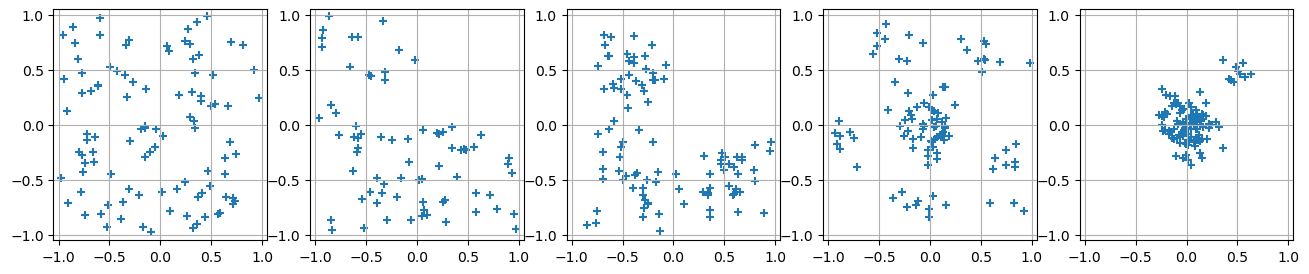

In [4]:
from utils import get_hypercube_data, get_corner_data, get_circle_data

# generate data
desired_n, d, k = 100, 2, 3
X_uniform = get_hypercube_data(desired_n, d, border=.99)
X_subcube = get_hypercube_data(desired_n, d, border=.99, remove_subcube=True)
X_cluster = get_corner_data(desired_n, d, k, border=.99)
X1 = get_circle_data(desired_n/2, d, 5, radius=.8, variance=1/50, border=.99)
X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
X_subbubbles = np.concatenate((X1, X2))
X1 = get_circle_data(10, d, 1, radius=.7, variance=1/300, border=.99)
X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
X_outlier = np.concatenate((X1, X2))

# plot
xylim = 1.05
Xs = [X_uniform, X_subcube, X_cluster, X_subbubbles, X_outlier]
plt.figure(figsize=(16,3))
for i_plot, X_plot in enumerate(Xs):
    plt.subplot(1,len(Xs),i_plot+1), plt.grid(), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], marker="+");

### Sensitivity

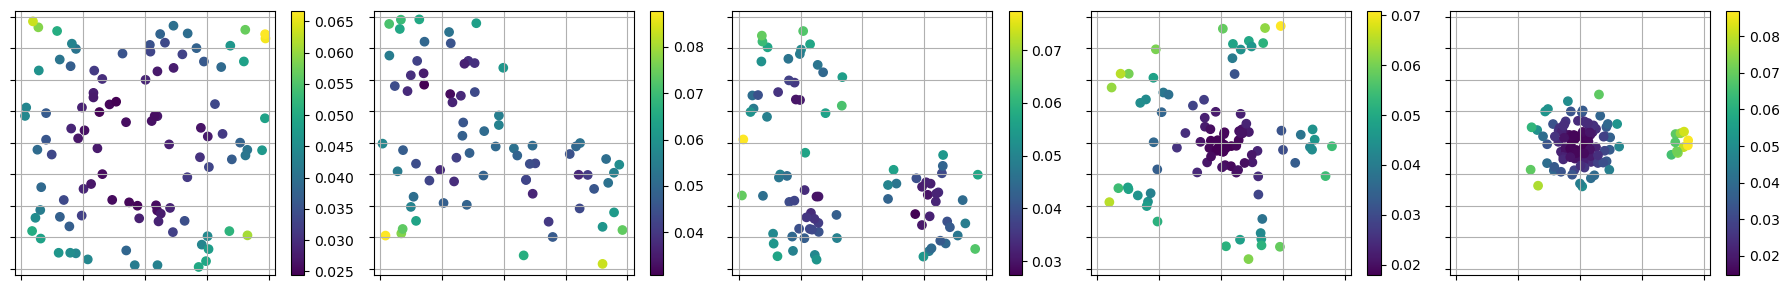

In [3]:
from utils import get_true_sensit

# compute and plot sensitivity
plt.figure(figsize=(18,3))
for i_plot, X_plot in enumerate(Xs):
    sensit = get_true_sensit(X_plot, k)
    plt.subplot(1,len(Xs),i_plot+1), plt.grid(), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], c=sensit), plt.colorbar();
    plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])
    plt.tight_layout()

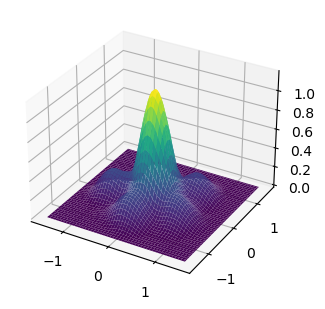

In [4]:
from sklearn.neighbors import KernelDensity
from interfaces import plot3d_func

# compute and plot KDE
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X_subbubbles)
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))
plt.figure(figsize=(8,4))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)

### Gaussian k-DPP weights check

empirically yields m=5.000, which should be close to m=5


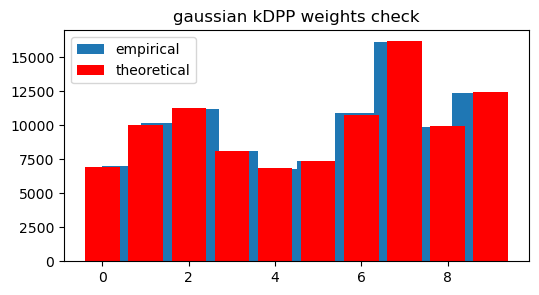

In [5]:
from samplers import gaussian_kernel, get_kDPP_weights, draw_gaussian_kDPP
 
d, n, m, k = 2, 10, 5, 3
X = get_hypercube_data(n, d, border=.99)
nb_samples = 20000
bandwidth = 1

likelihood = gaussian_kernel(X, bandwidth)
weights = get_kDPP_weights(likelihood, m)
samples, _ = draw_gaussian_kDPP(X, m, nb_samples, bandwidth)
samples = samples.flatten()
print(f"empirically yields m={(1/(n*weights)).sum():.3f}, which should be close to {m=}")
plt.figure(figsize=(6,3))
plt.hist(samples, density=False, label="empirical")
plt.bar(np.arange(len(X)), nb_samples/(n*weights), color='r', label="theoretical")
plt.title("gaussian kDPP weights check"), plt.legend();

### Sampling example

obtained n=294


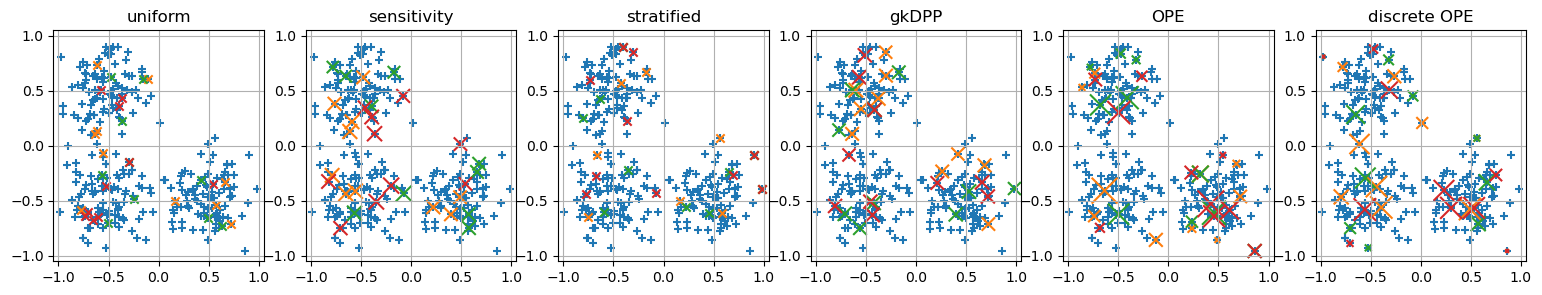

In [3]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE

# generate data
d, desired_n, m, k = 2, 300, 10, 1
nb_samples = 3
# X = get_hypercube_data(desired_n, d, border=.99, remove_subcube=False)
X = get_corner_data(desired_n, d, 3, border=.99)
# X = get_circle_data(desired_n, d, 2, radius=.7, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n/2, d, 3, radius=.8, variance=1/50, border=.99)
# X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
# X1 = get_circle_data(10, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
n = len(X)
print(f"obtained {n=}")

# sample
uniform_samples = draw_uniform(len(X), m, nb_samples)
X_uniform = X[uniform_samples]
sensit_samples, sensit_weights = draw_sensitivity(X, m, nb_samples, k, .1)
X_sensit = X[sensit_samples]
stratified_samples = draw_stratified(X, m, nb_samples)
X_stratified = X[stratified_samples]
gkDPP_samples, gkDPP_weights = draw_gaussian_kDPP(X, m, nb_samples, bandwidth=.1)
X_gkDPP = X[gkDPP_samples]
OPE_samples, OPE_weights = draw_OPE(X, m, nb_samples, ab_coeff=0, prop_uniform=.1)
X_OPE = X[OPE_samples]
dOPE_samples, dOPE_weights = draw_discrete_OPE(X, m, nb_samples)
X_dOPE = X[dOPE_samples]

# plot
titles = ["uniform","sensitivity","stratified","gkDPP","OPE","discrete OPE"]
weights = [None, sensit_weights, None, gkDPP_weights, OPE_weights, dOPE_weights]
plt.figure(figsize=(19,3))
for k, X_samples in enumerate([X_uniform, X_sensit, X_stratified, X_gkDPP, X_OPE, X_dOPE]):
    xylim = 1.05
    plt.subplot(1,len(titles),k+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker='+')
    for i_sample in range(nb_samples):
        weight = None
        if weights[k] is not None: weight= 100*m*weights[k][i_sample]
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight)
    plt.title(titles[k]), plt.grid()
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])

## Statistics

### Variance rate

In [4]:
from utils import get_hypercube_data, get_corner_data, get_circle_data
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE
from utils import loss, relative_error
from interfaces import save_variables_as_dict
from sklearn.neighbors import KernelDensity

# data parameters
d, desired_n, k = 2, 1024, 1    # 2, 1024, 3
X = get_hypercube_data(desired_n, d, border=.99)
# X = get_corner_data(desired_n, d, 3, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n/5, d, 2, radius=.7, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n, d, 3, radius=.8, variance=1/50, border=.99)
# X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
# X1 = get_circle_data(desired_n/5, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(4*desired_n/5, d, 1, radius=0, variance=1/50, border=.99)
# X1 = get_circle_data(10, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
n = len(X)
print(f"obtained n={n}")

# repetitions parameters
nb_rep = 100 # 500
ms = np.arange(1,14, dtype=int)**2 # (1,14)
print(f"m list={ms}")
queries = X[np.random.choice(n, (10,k), replace=False)] # 50
# queries = np.zeros((1,1,X.shape[-1]))
bandwiths = [.01, .03, .05, .1, .3]
# bandwiths = [.003, .01, .03, .1, .3]

# init
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X))
SE_means, SE_stds, relerrs = [], [], []
nb_ms, nb_queries = len(ms), len(queries)

for i_query, query in enumerate(queries):
    # select query
    loss_X = loss(X, query) 
    print(f"draw query {i_query+1}/{nb_queries}")

    for m in ms:
        print(f"{m=}")
        # sample
        uniform_samples = draw_uniform(n, m, nb_rep)
        sensit_samples, sensit_weights = draw_sensitivity(X, m, nb_rep, k, delta=.1)
        gkDPP_samples, gkDPP_weights = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=.1)
        OPE_samples, OPE_weights = draw_OPE(X, m, nb_rep, gamma_X=kde_distr, prop_uniform=0)
        dOPE_samples, dOPE_weights = draw_discrete_OPE(X, m, nb_rep)
        stratified_samples = draw_stratified(X, m, nb_rep)
        
        # gkDPP_samples1, gkDPP_weights1 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[0])
        # gkDPP_samples2, gkDPP_weights2 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[1])
        # gkDPP_samples3, gkDPP_weights3 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[2])
        # gkDPP_samples4, gkDPP_weights4 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[3])
        # gkDPP_samples5, gkDPP_weights5 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[4])

        # compute loss
        loss_uniform = loss(X, query, uniform_samples)
        loss_sensit = loss(X, query, sensit_samples, sensit_weights)
        loss_gkDPP = loss(X, query, gkDPP_samples, gkDPP_weights)
        loss_OPE = loss(X, query, OPE_samples, OPE_weights)
        loss_dOPE = loss(X, query, dOPE_samples, dOPE_weights)
        loss_stratified = loss(X, query, stratified_samples)

        # loss_gkDPP1 = loss(X, query, gkDPP_samples1, gkDPP_weights1)
        # loss_gkDPP2 = loss(X, query, gkDPP_samples2, gkDPP_weights2)
        # loss_gkDPP3 = loss(X, query, gkDPP_samples3, gkDPP_weights3)
        # loss_gkDPP4 = loss(X, query, gkDPP_samples4, gkDPP_weights4)
        # loss_gkDPP5 = loss(X, query, gkDPP_samples5, gkDPP_weights5)

        # compute metrics
        loss_samples = np.array([loss_uniform, loss_sensit, loss_gkDPP, loss_OPE, loss_dOPE, loss_stratified])
        # loss_samples = np.array([loss_uniform, loss_sensit, loss_gkDPP, loss_OPE, loss_dOPE])
        # loss_samples = np.array([loss_uniform, loss_sensit, loss_OPE, loss_dOPE])
        # loss_samples = np.array([loss_uniform, loss_gkDPP1, loss_gkDPP2, loss_gkDPP3, loss_gkDPP4, loss_gkDPP5])
        SEs = (loss_samples - loss_X)**2
        SE_means.append(SEs.mean(-1))
        SE_stds.append(SEs.std(-1))
        relerrs.append(relative_error(loss_samples, loss_X))

# aggregate metrics
relerrs_sup = np.array(relerrs).reshape(nb_queries, nb_ms, -1, nb_rep).max(0)
SE_means, SE_stds = np.array(SE_means).reshape(nb_queries, nb_ms, -1), np.array(SE_stds).reshape(nb_queries, nb_ms, -1)
SE_means_argmax = SE_means.argmax(0)
arr1, arr2 = np.ogrid[:nb_ms,:SE_means.shape[-1]]
SE_means_sup = SE_means[SE_means_argmax, arr1, arr2]
SE_stds_sup = SE_stds[SE_means_argmax, arr1, arr2]

save_variables_as_dict("relerrs_sup, SE_means_sup, SE_stds_sup", output_name="uniform")

obtained n=1024
m list=[  1   4   9  16  25  36  49  64  81 100 121 144 169]
draw query 1/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 2/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 3/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 4/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 5/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 6/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 7/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 8/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 9/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
draw query 10/10
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169


c:\Users\yugos\anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


ValueError: could not broadcast input array from shape (13,6,100) into shape (13,6)

In [18]:
delta_quant = .1 # .1, .01
relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)

In [19]:
output_dict = {"relerr_quant":relerr_quant, "SE_means_sup":SE_means_sup, "SE_stds_sup":SE_stds_sup}
np.save("./npys/output_uniform_toussa_quantile", output_dict)


In [61]:
aaa = np.load("./npys/output_uniform_toussa_quantile.npy", allow_pickle=True)
aaa.item()

{'relerr_quant': array([[1.87761105, 1.46972506, 2.13013015, 3.05629827, 1.87771724,
         1.91065329],
        [0.9560574 , 0.83561175, 1.02619404, 2.00177116, 0.58112039,
         0.6794741 ],
        [0.68121198, 0.54935907, 0.64372237, 1.03011428, 0.45847369,
         0.3257307 ],
        [0.47524709, 0.52113889, 0.46948263, 0.52790639, 0.34945188,
         0.19882898],
        [0.38012828, 0.37578069, 0.37813324, 0.32200034, 0.24783811,
         0.13641745],
        [0.32722978, 0.3176182 , 0.27580212, 0.21478113, 0.19274605,
         0.10957112],
        [0.28637612, 0.2447315 , 0.21862413, 0.17601377, 0.14380696,
         0.09507566],
        [0.25359782, 0.22611131, 0.19480143, 0.14487701, 0.11700107,
         0.08579084],
        [0.22176768, 0.20121291, 0.15446308, 0.11957857, 0.09944304,
         0.07631231],
        [0.19657895, 0.18429408, 0.14923429, 0.10499238, 0.08908968,
         0.06868525],
        [0.17936209, 0.15823464, 0.11321606, 0.09174269, 0.0755684 ,
     

In [16]:
relerrs_sup, SE_means_sup, SE_stds_sup = np.load("./npys/uniform_n1024_m1-64_1means10.npy")

In [17]:
from interfaces import get_save_output_interface
# save output
output_list = [relerrs_sup, SE_means_sup, SE_stds_sup]
output_interface = get_save_output_interface(output_list)
display(output_interface)

interactive(children=(Text(value='./npys/', description='output_directory'), Text(value='OUTPUT', description=…

In [19]:
np.load("./npys/OUTPUT.npy", allow_pickle=True)

array({'output': array([[1.85038745e+00, 1.86697403e+00, 2.90911868e+00, 9.93357062e+00,
        2.51135453e+00, 2.22226354e+00],
       [6.46292155e-01, 6.88042849e-01, 8.14972536e-01, 5.21666602e+00,
        5.00140959e-01, 2.10109311e-01],
       [2.42709541e-01, 2.60747381e-01, 3.62491838e-01, 1.21750198e+00,
        2.17609354e-01, 6.59411276e-02],
       [1.59648093e-01, 1.42746671e-01, 1.25148633e-01, 3.38143036e-01,
        9.69613832e-02, 1.29923782e-02],
       [1.67309582e-01, 8.20282828e-02, 8.97544346e-02, 8.79978643e-02,
        4.08479093e-02, 9.03791746e-03],
       [9.38718027e-02, 7.23942896e-02, 9.08464182e-02, 4.26594527e-02,
        3.69682552e-02, 4.76576978e-03],
       [6.35061004e-02, 4.02442623e-02, 3.44695241e-02, 2.82932853e-02,
        2.08594998e-02, 2.20432787e-03],
       [4.60090925e-02, 3.13171772e-02, 3.21983602e-02, 2.14055510e-02,
        1.20586595e-02, 1.73936859e-03]])}, dtype=object)

In [52]:
def my_plot(use_TeX, font_size):
    
    # plot
    nb_stds = 1*nb_rep**(-.5)
    xylim = 1.05
    plt.figure(figsize=(15*2**.5,5))
    plt.subplot(131), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker="+", label="data")
    X_samples, X_weights = X[OPE_samples[0]], 100*m*OPE_weights[0]
    plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label="OPE sample", s=X_weights)
    # plt.title(f"$n={n}, m={m}$"), 
    plt.xlabel(f"$n={n}, m={m}$"), 
    plt.legend(), plt.grid()

    plt.subplot(132)
    legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE","stratified"]
    # legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE"]
    # legends = ["uniform","sensitivity","OPE","discrete OPE"]
    # legends = ["uniform"]+["gkDPP, h="+str(bandwith) for bandwith in bandwiths]
    colors = ["cyan","blue","darkviolet","red","orange","maroon"]
    # colors = ["cyan","mediumblue","red","orange"]
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, SE_means_sup, label=legends, marker="+")
    for k, legend in enumerate(legends):
        plt.fill_between(ms, SE_means_sup[:,k]+nb_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-nb_stds*SE_stds_sup[:,k], alpha=.5)
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), plt.legend(), plt.grid(), 

    plt.subplot(133)
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, relerr_quant, label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    # plt.xticks(fontsize=14, rotation=90)
    plt.legend(), plt.grid(),


# interact_man = interact_manual.options(manual_name="plot figure")
# interact_man(plot_figure, 
#                 use_TeX=False, 
#                 font_size={"10 (default)":10, "12":12, "14":14})
# interact_man = interact_manual.options(manual_name="save figure")
# interact_man(save_figure, manual_name="save figure",
#                 fig_directory="./figs/", 
#                 fig_fileprefix="sqrt2_default_tight4")

interactive(children=(Checkbox(value=False, description='use_TeX'), Dropdown(description='font_size', options=…

interactive(children=(Text(value='./figs/', description='fig_directory'), Text(value='sqrt2_default_tight4', d…

<function __main__.save_figure(fig_directory, fig_fileprefix)>

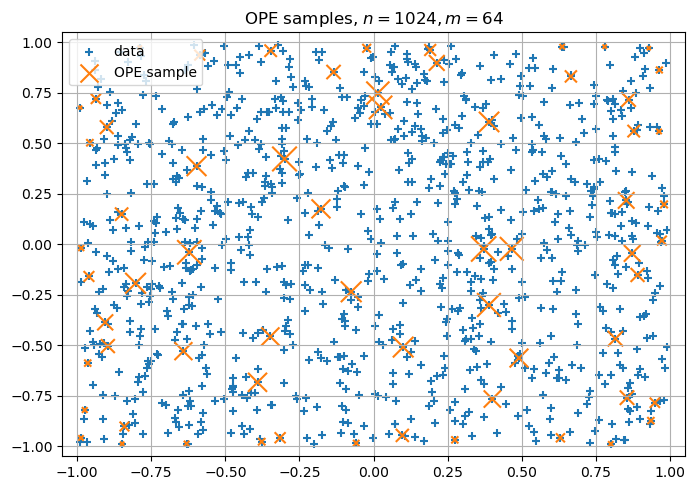

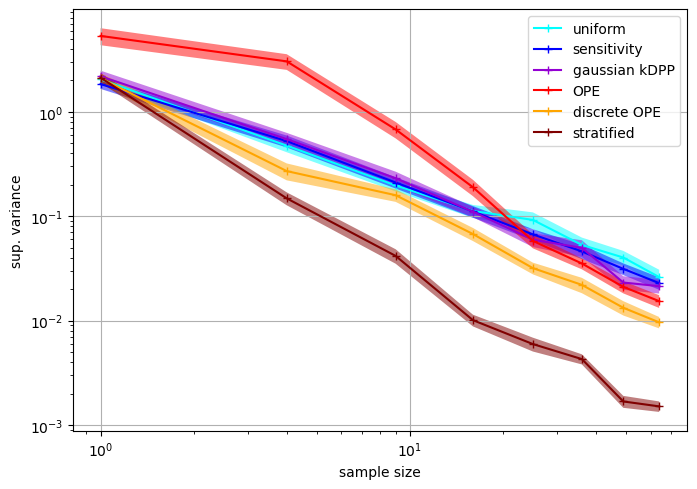

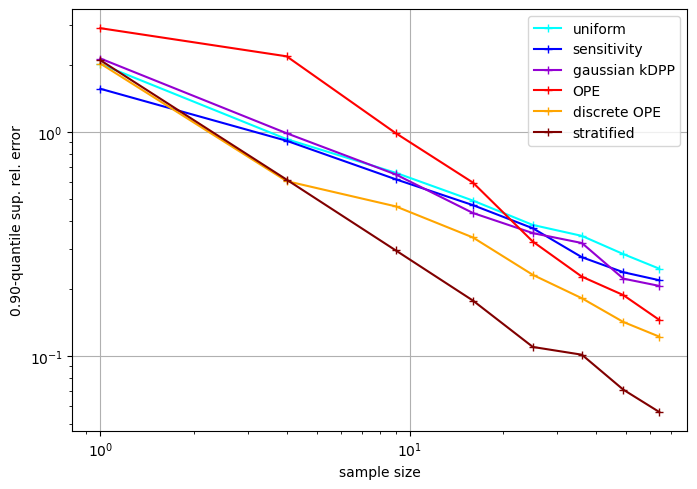

In [12]:
fig_filename = "./figs/test/uniform"
# plot and save
nb_stds = 1*nb_rep**(-.5)
xylim = 1.05
plt.figure(figsize=(5*2**.5,5))
# plt.subplot(131), 
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
plt.scatter(X[:,0], X[:,1], marker="+", label="data")
X_samples, X_weights = X[OPE_samples[0]], 100*m*OPE_weights[0]
plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label="OPE sample", s=X_weights)
plt.title(f"OPE samples, $n={n}, m={m}$"), 
plt.legend(), plt.grid(), plt.tight_layout(), 
plt.savefig(fig_filename+"_samples")
plt.show();

plt.figure(figsize=(5*2**.5,5))
# plt.subplot(132)
legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE","stratified"]
# legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE"]
# legends = ["uniform","sensitivity","OPE","discrete OPE"]
# legends = ["uniform"]+["gkDPP, h="+str(bandwith) for bandwith in bandwiths]
colors = ["cyan","blue","darkviolet","red","orange","maroon"]
# colors = ["cyan","mediumblue","red","orange"]
plt.gca().set_prop_cycle(color=colors)
plt.plot(ms, SE_means_sup, label=legends, marker="+")
for k, legend in enumerate(legends):
    plt.fill_between(ms, SE_means_sup[:,k]+nb_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-nb_stds*SE_stds_sup[:,k], alpha=.5)
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), plt.legend(), plt.grid(), plt.tight_layout(), 
plt.savefig(fig_filename+"_supvar")

plt.figure(figsize=(5*2**.5,5))
# plt.subplot(133)
delta_quant = .1 # .1, .01
relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
plt.gca().set_prop_cycle(color=colors)
plt.plot(ms, relerr_quant, label=legends, marker="+")
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
# plt.xticks(fontsize=14, rotation=90)
plt.legend(), plt.grid(), plt.tight_layout(), 
plt.savefig(fig_filename+"_suprel")
plt.show();

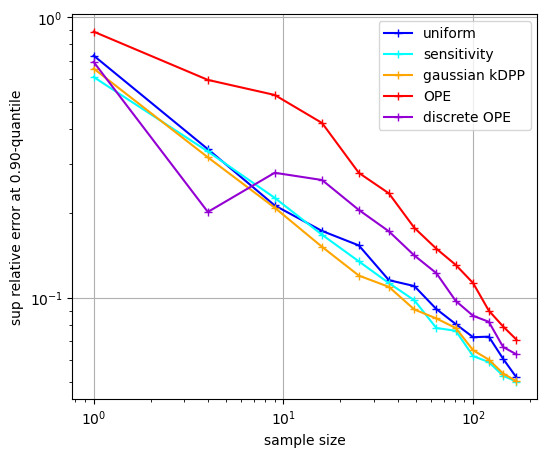

In [10]:
plt.figure(figsize=(6,5))
delta1, delta2 = .1, .01
relerr_quant1, relerr_quant2 = np.quantile(relerrs_sup, 1-delta1, axis=-1), np.quantile(relerrs_sup, 1-delta2, axis=-1)
plt.gca().set_prop_cycle(color=colors)
plt.plot(ms, relerr_quant1, label=legends, marker="+")
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"sup relative error at {1-delta1:.2f}-quantile")
plt.legend(), plt.grid(), plt.show();

In [47]:
np.save("./npys/uniform_n1024_m1-64_1means10.npy", [relerr_quant, SE_means_sup, SE_stds_sup])

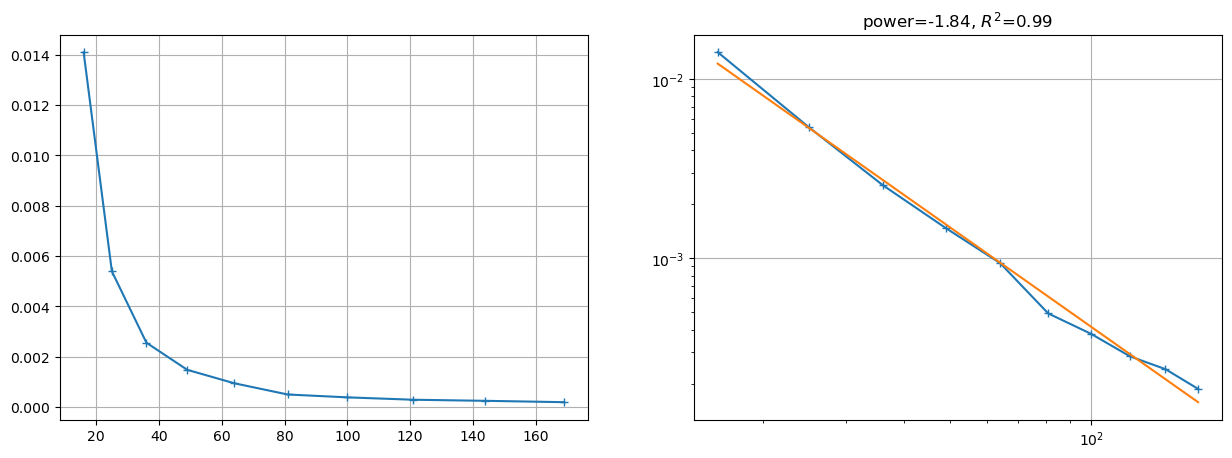

In [44]:
k_start, k_end = 3, None
plt.figure(figsize=(15,5))
fitted_reg = power_regression(ms[k_start:k_end], SE_means[:,2][k_start:k_end])

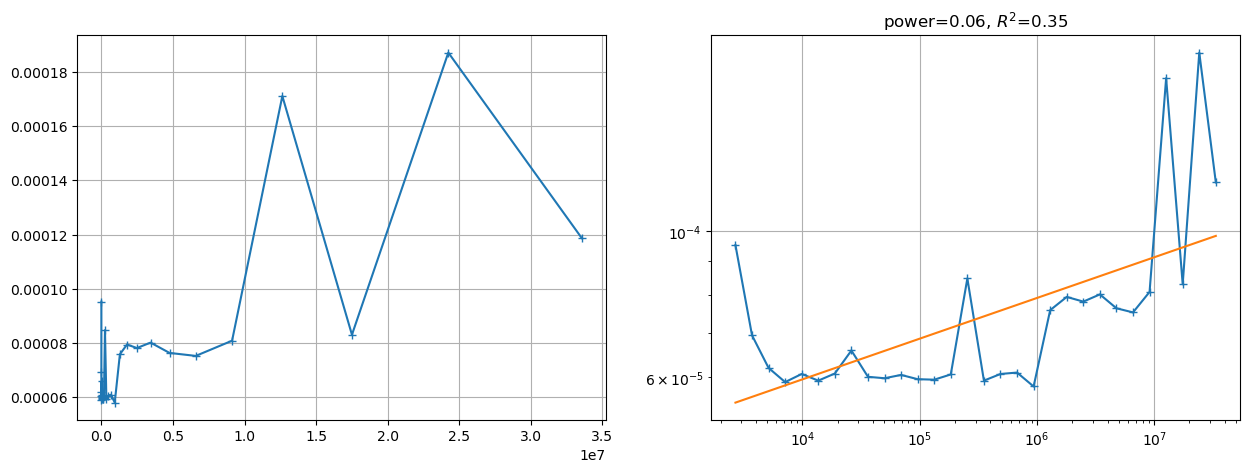

In [27]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    plt.subplot(121)
    plt.plot(x, y, marker="+"), plt.grid()
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    
    plt.subplot(122)
    plt.plot(x, y, marker="+")
    plt.plot(x, np.exp(reg.predict(logx)))
    plt.xscale('log'), plt.yscale('log')
    plt.title(f"power={power[0]:.2f}, $R^2$={R_squared:.2f}"), plt.grid();
    return reg

k_start = 20
plt.figure(figsize=(15,5))
fitted_reg = power_regression(n_list[k_start:], elapsed_times[k_start:])

### Benchmark DPPy sample_exact

In [26]:
from timeit import default_timer as timer
elapsed_times = []
n_list = []
d, n, nb_rep = 2, 2000, 10
ns = np.round(np.logspace(2, 25, num=50, base=2)).astype(int) # 20
# ns = np.arange(1, 30)**4
print(ns)
ab_coeff = 0
ab_coeff_array = np.zeros((d,2)) + ab_coeff
for n in ns:
    print(f"n={n}")
    start_time = timer()
    for rep in range(nb_rep):
        # X = get_hypercube_data(n, d)
        # obtain P which decompose continuous DPP K = PP^T
        # dpp = MultivariateJacobiOPE(m, ab_coeff_array)
        # polynom_X = dpp.eval_multiD_polynomials(X)
        # eig_vals, eig_vecs, weights = draw_OPE(X, int(m), gamma_X=.25)
        # OPE_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], nb_samples=2)
        # gamma_tilde = stats.gaussian_kde(X.T)
        # gamma_X = gamma_tilde.pdf(X.T)
        truc= np.round(n*np.random.rand(nb_rep))
    n_list.append(n)
    elapsed_times.append(timer() - start_time)

[       4        6        8       11       15       20       28       39
       54       75      104      143      198      275      380      527
      729     1010     1398     1935     2680     3710     5136     7111
     9846    13632    18874    26131    36179    50090    69351    96018
   132939   184057   254831   352820   488487   676320   936380  1296439
  1794947  2485144  3440736  4763774  6595549  9131681 12643011 17504524
 24235395 33554432]
n=4
n=6
n=8
n=11
n=15
n=20
n=28
n=39
n=54
n=75
n=104
n=143
n=198
n=275
n=380
n=527
n=729
n=1010
n=1398
n=1935
n=2680
n=3710
n=5136
n=7111
n=9846
n=13632
n=18874
n=26131
n=36179
n=50090
n=69351
n=96018
n=132939
n=184057
n=254831
n=352820
n=488487
n=676320
n=936380
n=1296439
n=1794947
n=2485144
n=3440736
n=4763774
n=6595549
n=9131681
n=12643011
n=17504524
n=24235395
n=33554432


In [25]:
np.random.choice(n, nb_rep), np.random.rand(n, nb_rep).shape

(array([20451574,  6466630, 30246717, 25200919,  1867114, 11104117,
         2257348, 16958323,  4892921, 30294148]),
 (33554432, 10))